<a href="https://colab.research.google.com/github/mailazorzan/parkinson/blob/main/parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson

Os dados do arquivo CSV contêm uma instância correspondente a uma gravação de voz. São cerca de seis registros por paciente, o nome do paciente está identificado na primeira coluna.

Atributos do conjunto de dados:
*    name - nome do assunto ASCII e número de gravação;
*    MDVP:Fo(Hz) - Frequência fundamental vocal média;
*    MDVP:Fhi(Hz) - Frequência fundamental vocal máxima;
*    MDVP:Flo(Hz) - Frequência fundamental vocal mínima;
*    MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Várias medidas de variação na frequência fundamental;
*    MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Várias medidas de variação de amplitude;
*    NHR,HNR - Duas medidas de proporção de ruído para componentes tonais na voz
status - Estado de saúde do sujeito: 1 = Parkinson, 0 = Saudável;
*    RPDE,D2 - Duas medidas de complexidade dinâmica não linear;
*    DFA - Expoente de dimensionamento fractal de sinal;
*    spread1,spread2,PPE - Três medidas não lineares de variação da frequência fundamental.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('./drive/MyDrive/Portfolio/Parkinson/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [5]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

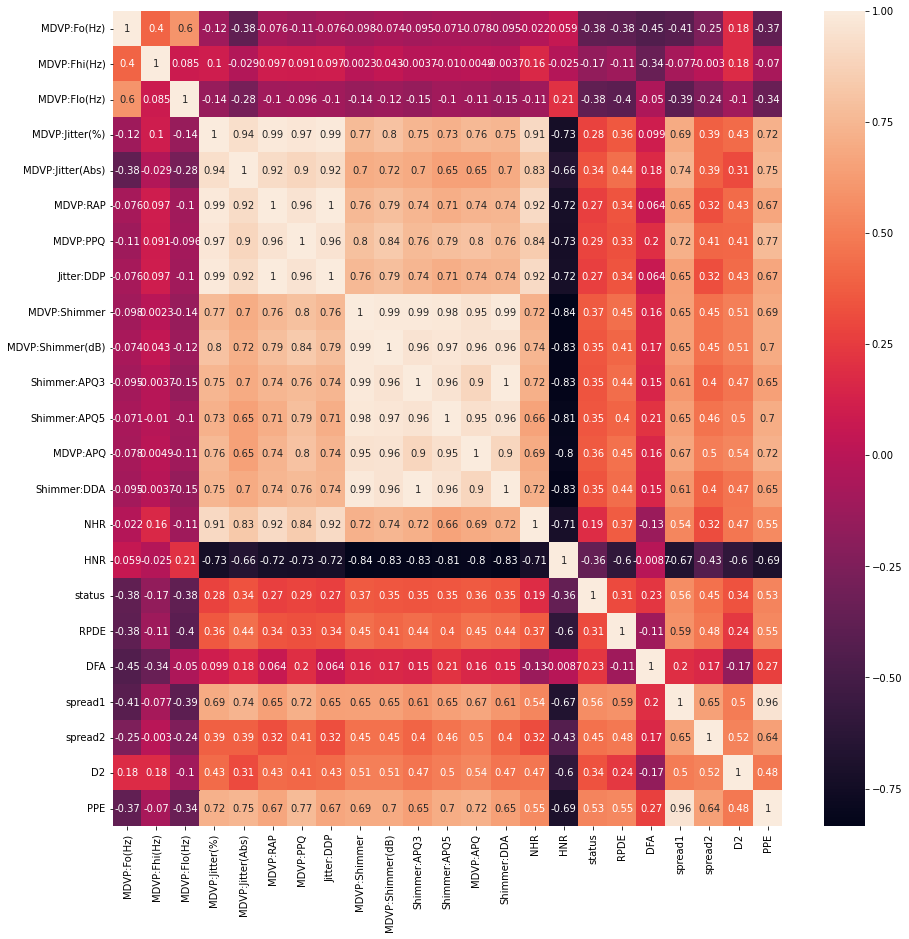

In [6]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(df.corr(), annot=True);

In [7]:
# Definição do percentual de correlação
corr_pct = 0.98

col_corr = set()
for i in range(len(df.corr().columns)):
    for j in range(i):
        if abs(df.corr().iloc[i, j]) > corr_pct:
          print(f'{df.corr().columns[i]} and {df.corr().columns[j]} correlated by {df.corr().iloc[i, j]}')
          col = df.corr().columns[i]
          col_corr.add(col)
print(col_corr, len(col_corr), type(col_corr))


MDVP:RAP and MDVP:Jitter(%) correlated by 0.9902755852458308
Jitter:DDP and MDVP:Jitter(%) correlated by 0.9902762153275696
Jitter:DDP and MDVP:RAP correlated by 0.999999600104134
MDVP:Shimmer(dB) and MDVP:Shimmer correlated by 0.9872578145507641
Shimmer:APQ3 and MDVP:Shimmer correlated by 0.9876250519099836
Shimmer:APQ5 and MDVP:Shimmer correlated by 0.9828354477070599
Shimmer:DDA and MDVP:Shimmer correlated by 0.9876256527301991
Shimmer:DDA and Shimmer:APQ3 correlated by 0.9999999636932829
{'MDVP:RAP', 'Jitter:DDP', 'Shimmer:APQ3', 'Shimmer:DDA', 'Shimmer:APQ5', 'MDVP:Shimmer(dB)'} 6 <class 'set'>


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


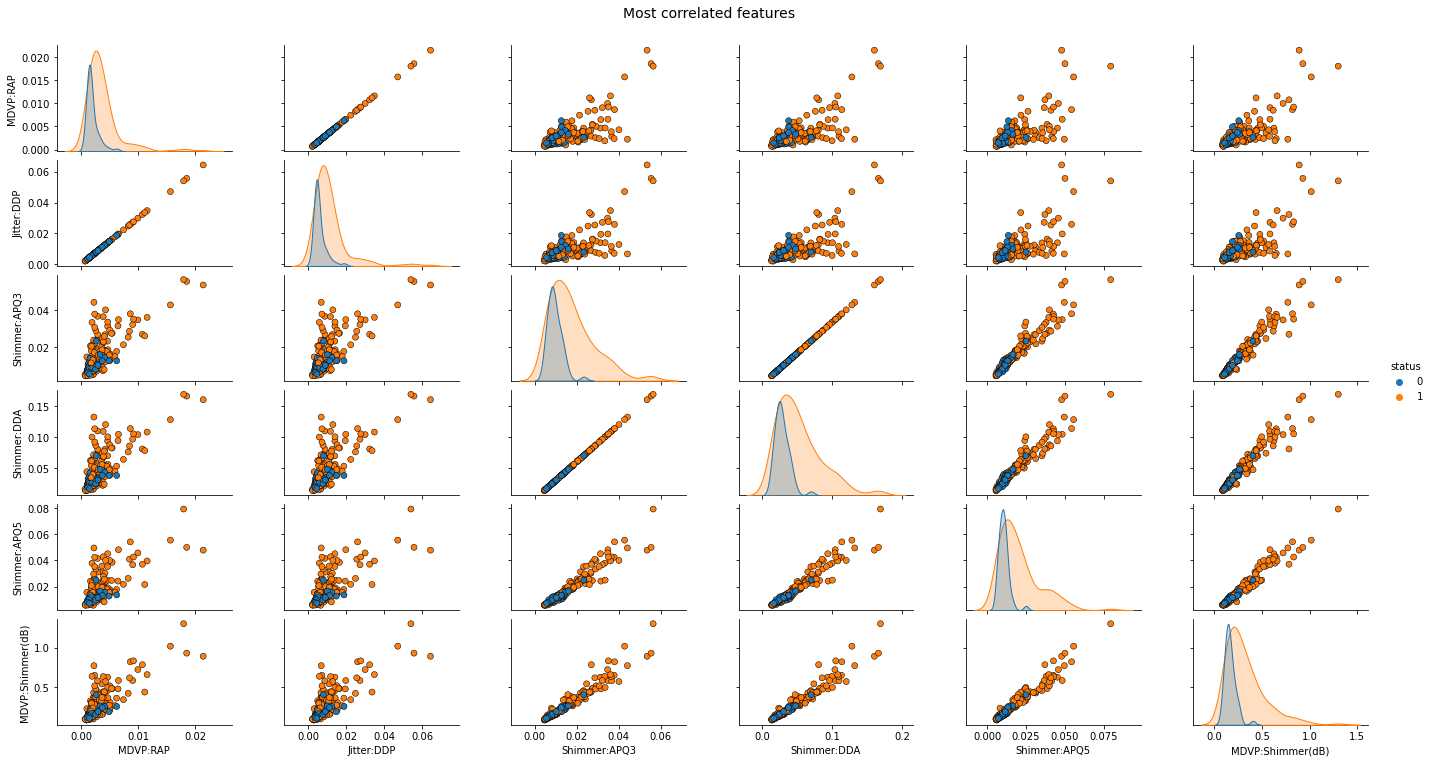

In [8]:
# Scatter Plot with Hue for visualizing data in 3-D
df_join = pd.concat([df[col_corr],df['status']], axis=1)

pp = sns.pairplot(df_join, hue="status", size=1.8, aspect=1.8, 
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Most correlated features', fontsize=14)
plt.show()


In [9]:
col_drop = ['MDVP:Jitter(%)', 'MDVP:RAP', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA', 'spread1']
df = df.drop(col_drop, axis=1)
df.shape

(195, 15)

In [10]:
# Distribuição do target 
df['status'].value_counts()

1    147
0     48
Name: status, dtype: int64

In [11]:
#Get the features and labels
features=df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values

In [12]:
#Get the count of each label (0 and 1) in labels
print(labels[labels==1].shape[0], labels[labels==0].shape[0])

147 48


In [13]:
#Scale the features to between -1 and 1
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(features)
y=labels

In [14]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)

In [15]:
#Train the model
model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier()

In [16]:
#Calculate the accuracy
y_pred=model.predict(x_test)
print(accuracy_score(y_test, y_pred)*100)

97.43589743589743
